In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.style.use('seaborn-bright')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.graphics.tsaplots import *
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\moham\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Load Dataset
data = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\QBElec.csv')
HUElec = pd.melt(data, id_vars=["Date"], var_name='time')
HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
HUElec = HUElec.set_index('Datetime')
HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

# View formatted data
HUElec.head()

,value
Datetime,
2008-03-03 00:00:00,0.0
2008-03-03 00:30:00,0.0
2008-03-03 01:00:00,0.0
2008-03-03 01:30:00,0.0
2008-03-03 02:00:00,0.0


In [4]:
data = HUElec.resample(rule='D').mean().copy()

data.fillna(method='ffill',  inplace=True)

data.head()

,value
Datetime,
2008-03-03,50.036833
2008-03-04,79.146396
2008-03-05,80.725021
2008-03-06,79.155750
2008-03-07,77.895188


In [5]:
def create_features(df, target_variable):
    """
    Creates time series features from datetime index
    
    Args:
        df (float64): Values to be added to the model incl. corresponding datetime
                      , numpy array of floats
        target_variable (string): Name of the target variable within df   
    
    Returns:
        X (int): Extracted values from datetime index, dataframe
        y (int): Values of target variable, numpy array of integers
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month',
           'dayofyear','dayofmonth','weekofyear']]
    if target_variable:
        y = df[target_variable]
        return X, y
    return X

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    #print('Evaluation metric results: ')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)}',end='\n\n')

In [8]:
from pmdarima.model_selection import train_test_split as time_train_test_split

X = data['value']

# Test Size = 20%
train_data, test_data = time_train_test_split(X, test_size=int(len(data)*0.2))

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

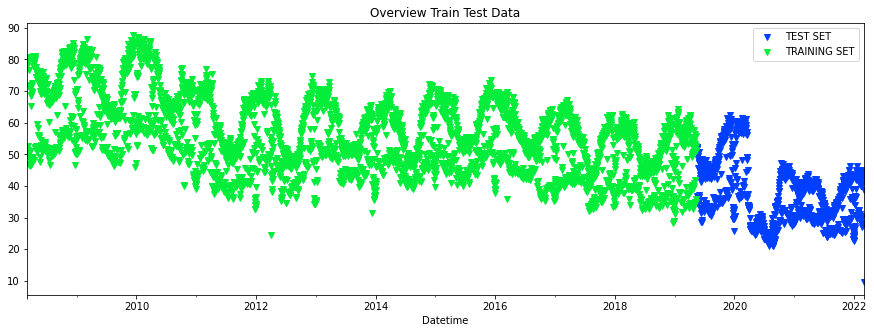

In [9]:
Overview_Train_Test_Data = test_data \
    .rename(columns={'value': 'TEST SET'}) \
    .join(train_data.rename(columns={'value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Overview Train Test Data', style='v')

In [10]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

trainX, trainY = create_features(train_data_copy, target_variable='value')
testX, testY = create_features(test_data_copy, target_variable='value')

<ipython-input-5-2394359a5459>:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-5-2394359a5459>:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [17]:
lgb = LGBMRegressor(boosting_type='dart',
    n_estimators=10000,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=0.3, 
    max_depth=7,
)

lgb.fit(trainX, trainY, eval_set=[(trainX, trainY), (testX, testY)], early_stopping_rounds=50, verbose=0)

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


LGBMRegressor(boosting_type='dart', colsample_bytree=0.3, max_depth=7,
              n_estimators=10000, subsample=0.5)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

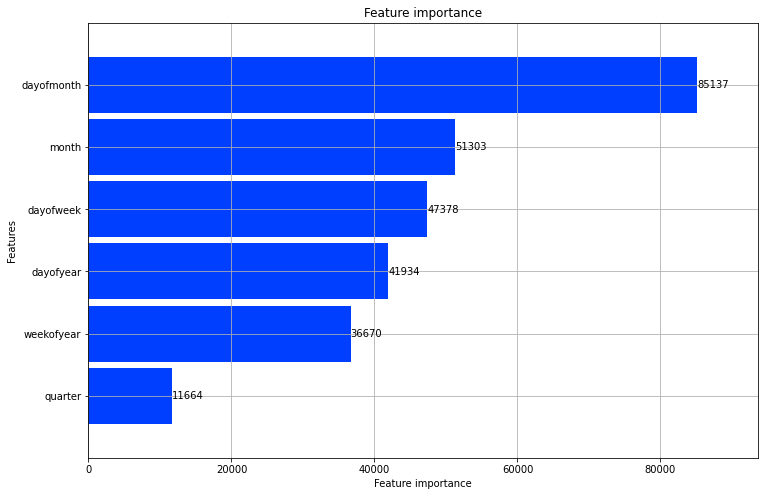

In [18]:
# from xgboost import plot_importance
from lightgbm import plot_importance

feature_importance = plot_importance(lgb, height=0.9)
feature_importance

In [19]:
predicted_results = lgb.predict(testX)
predicted_results

array([62.69155925, 63.55912654, 61.25607851, ..., 48.59257291,
       65.83336206, 69.03867351])

In [20]:
timeseries_evaluation_metrics_func(testY, predicted_results)

MSE is : 450.5950369210123
MAE is : 19.465189201257086
RMSE is : 21.227223957008892
MAPE is : 58.57756010074803
R2 is : -3.648469414370836



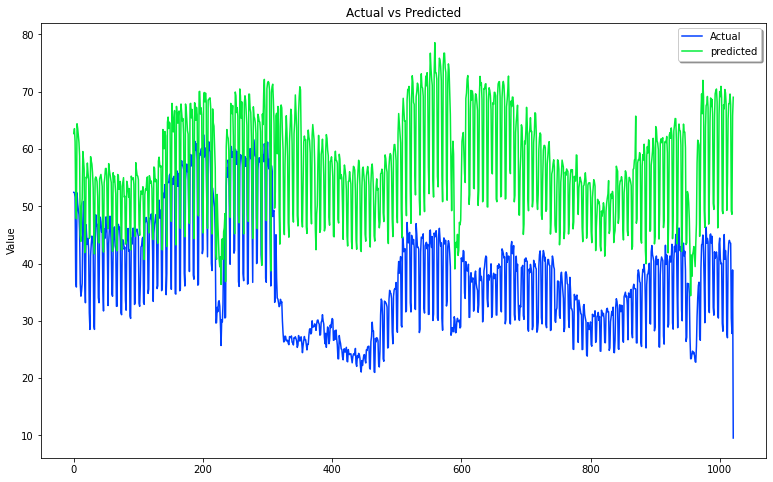

In [21]:
plt.figure(figsize=(13,8))
plt.plot(list(testY))
plt.plot(list(predicted_results))
plt.title("Actual vs Predicted")
plt.ylabel("Value")
plt.legend(('Actual','predicted'), shadow=True)
plt.show()

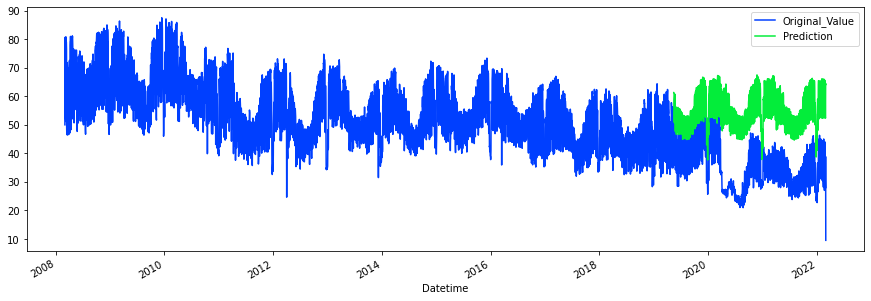

In [16]:
test_data['Prediction'] = predicted_results
pjme_all = pd.concat([test_data, train_data], sort=False)
pjme_all = pjme_all.rename(columns={'value':'Original_Value'})

Overview_Complete_Data_And_Prediction = pjme_all[['Original_Value','Prediction']].plot(figsize=(15, 5))